# Quantum walk search algorithm


$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$


In [175]:
import numpy as np
import networkx as nx
from networkx import hypercube_graph
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from typing import Callable
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator
from qiskit.tools.visualization import plot_histogram, plot_bloch_vector
from qiskit_aer import AerSimulator
from numpy import pi


## Base quantum computing concepts

The physics of quantum computing is marvelous, but very complex.

> If you think you understand quantum mechanics, you don't understand quantum mechanics.
>
> - Richard Feynman


### Hilbert space

Luckily, it is possible to abstract the inner working of a quantum computer using some mathematical abstractions.
The state of a quantum computer can be represented as a vector in a Hilbert space.
The Hilbert space $\mathcal{H}$ is a vector space with an inner product, and the inner product is defined as follows:

$$
\langle \psi | \phi \rangle = \sum_{i=1}^n \bar{\psi_i} \phi_i
$$

where $\psi$ and $\phi$ are two vectors in the Hilbert space, and $\bar{\psi}_i$ is the complex conjugate of $\psi_i$.

It is also possible to define the norm of a vector in the Hilbert space by using the inner product:

$$
\| \psi \| = \sqrt{\langle \psi | \psi \rangle}
$$


### Superposition

One of the peculiar properties of a quantum system is its ability to be in a superposition of states.
Mathematically, this means that a quantum state can be represented as a linear combination of other states:

$$
\ket{\psi_1}, \ket{\psi_2} \in \mathcal{H} \implies \ket{\psi} = \alpha \ket{\psi_1} + \beta \ket{\psi_2}, \ket{\psi} \in \mathcal{H} \\
\forall \alpha, \beta \in \mathbb{C}
$$


### Linear operators

Operating over the state of a quantum system means applying a linear operator to the state vector.
Linear operators over a $d$-dimensional Hilbert space may be represented as a $d \times d$ matrix.
They all follow the common mathematical rules associated with matrices.  
In particular, given an operator $A$, it satisfies the linearity condition:

$$
A(\alpha \ket{\psi_1} + \beta \ket{\psi_2}) = \alpha A(\ket{\psi_1}) + \beta A(\ket{\psi_2}) \\
\forall \alpha, \beta \in \mathbb{C}, \forall \ket{\psi_1}, \ket{\psi_2} \in \mathcal{H}
$$


### Normal unitary operators

A normal unitary operator is a linear operator that satisfies the following conditions:

$$
A^\dagger A = I \\
AA^\dagger = I \\
$$

where $A^\dagger$ is the complex conjugate of $A$ and $I$ is the identity matrix.

The reason why normal unitary operators are so important is because of their useful properties:

- the rows and columns of a normal unitary operator are orthonormal vectors
- they preserve the inner product and, by extension, the norm of the state vector
  - $\braket{\psi_1 A}{A \psi_2} = \bra{\psi_1} A^\dagger A \ket{\psi_2} = \braket{\psi_1}{\psi_2}$


### Tensor product

The tensor product is a mathematical operation that allows to join two systems together.
Given two matrices $A$ and $B$, their tensor product is defined as follows:

$$
A \otimes B = \begin{bmatrix} a_{11} B & a_{12} B & \dots & a_{1n} B \\ a_{21} B & a_{22} B & \dots & a_{2n} B \\ \vdots & \vdots & \ddots & \vdots \\ a_{m1} B & a_{m2} B & \dots & a_{mn} B \end{bmatrix}
$$


Similarly, given two vectors $\ket{\psi}$ and $\ket{\phi}$, their tensor product is defined as follows:


$$
\ket{\psi} \otimes \ket{\phi} = \begin{bmatrix} \psi_1 \\ \psi_2 \\ \vdots \\ \psi_n \end{bmatrix} \otimes \begin{bmatrix} \phi_1 \\ \phi_2 \\ \vdots \\ \phi_m \end{bmatrix} = \begin{bmatrix} \psi_1 \phi_1 \\ \psi_1 \phi_2 \\ \vdots \\ \psi_1 \phi_m \\ \psi_2 \phi_1 \\ \psi_2 \phi_2 \\ \vdots \\ \psi_2 \phi_m \\ \vdots \\ \psi_n \phi_1 \\ \psi_n \phi_2 \\ \vdots \\ \psi_n \phi_m \end{bmatrix}
$$


## Common operators

When dealing with quantum computing, there are some operators that are used very often.


### Pauli's operators

Four of the most common operators are:

- the identity operator, which does not change the state of the system
- the Pauli-X operator, which flips the state of the qubit
- the Pauli-Y operator, which rotates the state of the qubit by $\pi/2$
- the Pauli-Z operator, which flips the sign of the state of the qubit


In their matrix representation, they become:

$$
I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \\
X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \\
Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix} \\
Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}
$$


### Hadamard operator

The Hadamard operator is a normal unitary operator that maps the state $\ket{0}$ to $\ket{+}$ and $\ket{1}$ to $\ket{-}$, where $\ket{+}$ and $\ket{-}$ are the Hadamard basis states.

$$
\ket{+} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} \\
\ket{-} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ -1 \end{bmatrix} \\
\\
H = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \\
$$

The Hadamard operator is very useful because it allows to create superpositions of states.
When in a $\ket{-}$ or $\ket{+}$ state, measuring the qubit will collapse to either $0$ or $1$ with a probability of exactly $\frac{1}{2}$.
It can be seen as a perfectly balanced coin.


### Phase operator

The phase operator is able to rotate the state of the qubit by $\pi/2$ around the Z axis.

$$
S = \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix} \\
$$


## Quantum computation


### Qubit

The fundamental unit of quantum computation is the qubit.
It can be seen as the quantum equivalent of a classical bit, albeit with very different properties.
A qubit $\ket{\psi}$ is defined as the superposition of two states:

$$
\ket{0} = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
\ket{1} = \begin{bmatrix} 0 \\ 1 \end{bmatrix} \\
\ket{\psi} = \alpha \ket{0} + \beta \ket{1} \\
\alpha, \beta \in \mathbb{C}
$$


Another way to represent qubits is by using the Bloch sphere.  
The Bloch sphere is a three-dimensional representation of the qubit state.
Operators such as the Pauli-X, Pauli-Y and Pauli-Z operators can be used to rotate the qubit around the Bloch sphere.
We can simplify the notation of a qubit using the angles $\theta$ and $\phi$, defined from the $\ket{0}$ and the x point, respectively:

$$
\ket{\psi} = \cos \frac{\theta}{2} \ket{0} + e^{i \phi} \sin \frac{\theta}{2} \ket{1} \\
$$

Notice that such a vector is a unit vector: $\cos^2{\frac{\theta}{2}} + \sin^2 {\frac{\theta}{2}} = 1$.

This is the the qubit $\ket{+}$ on the Bloch sphere.


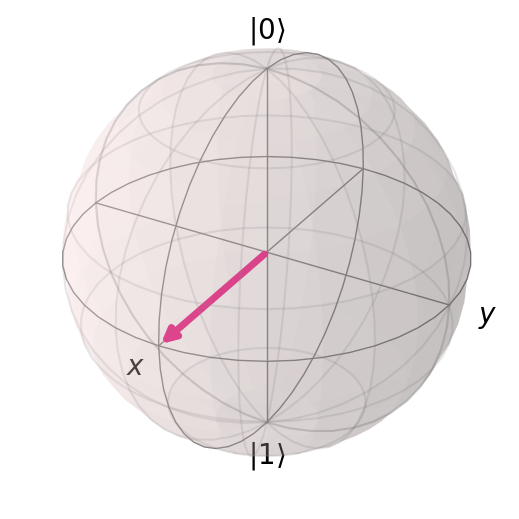

In [176]:
coords = [1, np.pi / 2, 0]  # [Radius, Theta, Phi]
plot_bloch_vector(coords, coord_type="spherical")


### Quantum gates

When seen in the context of quantum computing, the operators we have seen so far are called quantum gates.
They are usually represented by a square that applies the operator to the qubit.

Starting from a state $\psi_0 = \ket{0} \otimes \ket{0}$, the quantum circuit shown produces a final $\psi_f = (H \otimes I)(X \otimes Y)(H \otimes X)\ket{\psi}_0$.


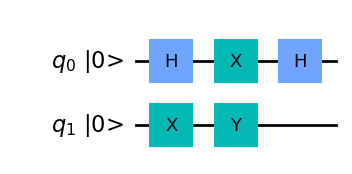

In [177]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.x(0)
qc.y(1)
qc.h(0)
qc.draw("mpl", initial_state=True)


### Controlled gates

Another important building block of quantum circuits are controlled gates.
They are gates that are applied to a qubit only if the controlling qubits are in a specific state, usually $\ket{1}$.
The controlled-NOT gate is the most common controlled gate, and the corresponding matrix is:

$$
CNOT = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix}
$$


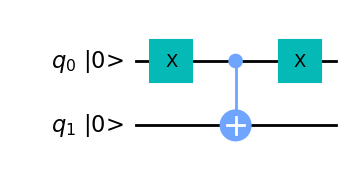

In [178]:
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(0, 1)
qc.x(0)
qc.draw("mpl", initial_state=True)


### Quantum algorithms

As seen before, it is possible to apply some unitary operators to a qubit, altering the state of the system.
Then, a quantum algorithm can be seen as a sequence of unitary operators applied to an initial state, in order to solve a problem.

$$
\ket{\psi_n} = U_n U_{n-1} \dots U_1 \ket{\psi_0}
$$

Finally, the result of the algorithm can be obtained by measuring the qubits.


## Classical Markov chains

A Markov chain can be seen as a set of nodes, linked to each other by a probability distribution.  
The transition between a node and the following is random and depends only on the probability of the outgoing links of the current node.  
This property is called **Markovian property**.


Markov chain can be further classified as **discrete** or **continuous**, depending the times steps.
Only **discrete** Markov chains are considered in this presentation.


### Transition matrix

The transition matrix is a square matrix, with the number of rows and columns equal to the number of nodes.  
It is used to describe the probability of transition between nodes.

The probability distribution after $t$ steps (or at time $t$) can be obtained by multiplying the transition matrix by itself $t$ times: $P^t$.

An example of a transition matrix could be

$$
P = \begin{pmatrix}
0.1 & 0.4 & 0.4 & 0.1 \\
0.2 & 0.3 & 0.2 & 0.0 \\
0.6 & 0.2 & 0.1 & 0.1 \\
0.1 & 0.1 & 0.3 & 0.8 \\
\end{pmatrix}
$$


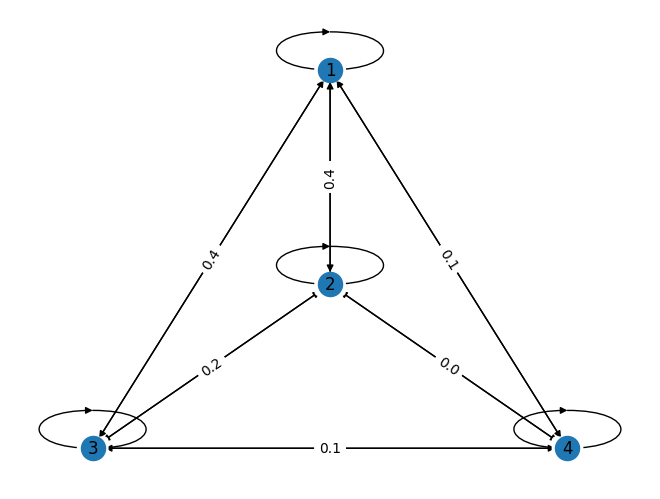

In [179]:
pos = {1: [0.75, 1.0], 2: [0.75, 0.15], 3: [0.5, -0.5], 4: [1.0, -0.5]}
U = [
    [0.1, 0.2, 0.6, 0.1],
    [0.4, 0.3, 0.2, 0.1],
    [0.4, 0.2, 0.1, 0.3],
    [0.1, 0.0, 0.1, 0.8],
]

G = nx.DiGraph(directed=True)
for i in range(1, 5):
    G.add_node(i)
    for j in range(1, 5):
        G.add_edge(i, j, weight=U[i - 1][j - 1])

nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos=pos, edge_labels=nx.get_edge_attributes(G, "weight")
)
plt.show()


## Quantum walk

Quantum walks are the equivalent to a classical Markov chain.  
Due to superposition, a quantum walk can take all possible path simultaneously until the measurement makes the system collapse.  
States can be manipulated so that some of them will cancel out, leaving only the desired one.


There are two main models used to implement a quantum walk: **coined walk** and **Szegedy walk**.
The two models can be equivalent under certain conditions.


### Coined walk

A coined walk can be exemplified by a walk over the integer's line.
The walker's position is represented with an integer  
A coin is used to decide where to move next, left or right.


In [180]:
n_steps = 50  # Number of steps the walker will take
pr = 0.5  # Probability of the walker stepping to the right
initial_position = 0  # Initial position of our walker


def random_walk(pr: float, n_steps: int, initial_pos: int) -> int:
    """Run a random walk with N steps and a probability of stepping to the right of pr.

    Args:
        pr: probability of stepping to the right
        N: number of steps
        i: initial position

    Returns:
        The final position of the walker
    """
    position = initial_pos

    for _ in range(n_steps):
        coin_flip = list(
            np.random.choice(2, 1, p=[1 - pr, pr])
        )  # Flips our weighted coin
        position += 2 * coin_flip[0] - 1  # Moves the walker according to the coin flip

    return position


print(f"The walker is located at: x = {random_walk(pr, n_steps, initial_position)}")


The walker is located at: x = -2


Once plotted, the distribution of such a walk corresponds to a binomial distribution.


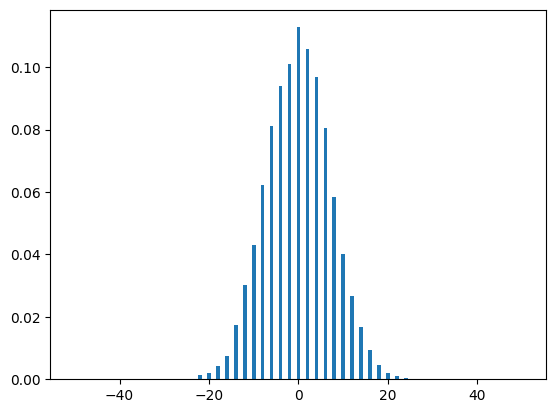

In [181]:
def dist(n_runs: int, n_steps: int):
    """Plot the distribution of the random walk.

    Args:
        runs: number of runs
        N: number of steps
    """
    positions = range(-1 * n_steps, n_steps + 1)
    instances = [0 for _ in range(-1 * n_steps, n_steps + 1)]

    for _ in range(n_runs):
        result = random_walk(pr, n_steps, initial_position)
        instances[positions.index(result)] += 1

    plt.bar(positions, [n / n_runs for n in instances])
    plt.show()


dist(10000, n_steps)


### Quantum coin walk

The coin walk algorithm can be translated in a pretty straightforward way to a quantum walk.
The position of the walker is encoded in a $n$ dimensional space, where $\frac{n}{2}$ is the maximum number of steps we allow the walker to take in one direction.
The resulting Hilbert space is $\mathcal{H}_p$, defined as $\mathcal{H}_p = \{\ket{j} : j = 0, \dots, n - 1 \}$.

To simulate the flip of a coin, we need to define an additional 2-dimensional space, $\mathcal{H}_c$, defined as $\mathcal{H}_c = \{\ket{i} : i = \downarrow, \uparrow \}$.

The space of all possible states of the system is obtained by combining the two components $\mathcal{H} = \mathcal{H_c} \otimes \mathcal{H_p}$.


#### Coin operator

While the coin can be represented with many different operators, the most common ones are:

$$
\text{Hadamard gate} \quad H = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 \\
1 & -1 \\
\end{bmatrix} \\
\ \\
\ \\
\text{Grover gate} \quad G = \begin{bmatrix}
\frac{2}{n} - 1 & \frac{2}{n} & \dots & \frac{2}{n} \\
\frac{2}{n} & \frac{2}{n} - 1 & \dots & \frac{2}{n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{2}{n} & \frac{2}{n} & \dots & \frac{2}{n} - 1 \\
\end{bmatrix}
$$


While the Hadamard gate produces a uniform distribution, the Grover gate can be used to produce a skewed distribution.
In the example above, applying the Grover gate to a state $\ket{000}$ produces this kind of probability distribution:


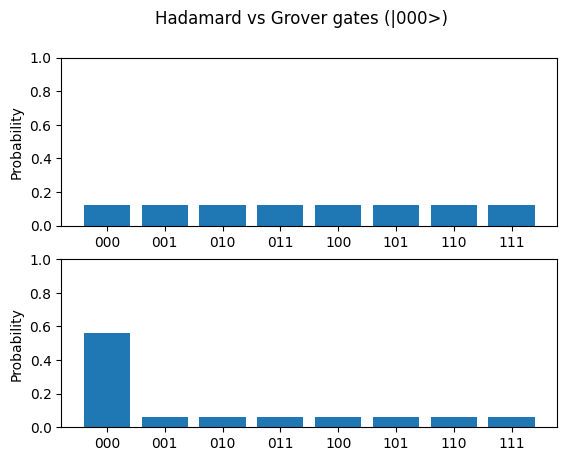

In [182]:
# Number of qubits
n = 3
# Initial state
initial_state = np.array([1] + [0] * (2**n - 1))
assert initial_state.size == 2**n

# Hadamard gate
hadamard_gate_base = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
hadamard_gate = hadamard_gate_base
for i in range(n - 1):
    hadamard_gate = np.kron(hadamard_gate, hadamard_gate_base)

# Grover's gate
grover_gate = np.full((2**n, 2**n), 1 / 2 ** (n - 1)) - np.eye(2**n)

# Apply gates
hadamard_res = np.dot(initial_state, hadamard_gate)
hadamard_res = np.square(hadamard_res)
grover_res = np.dot(initial_state, grover_gate)
grover_res = np.square(grover_res)

# Plot results
fig, axes = plt.subplots(2)
plt.suptitle("Hadamard vs Grover gates (|000>)")
for ax, res in zip(axes, [hadamard_res, grover_res]):
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.bar(tuple(bin(i)[2:].zfill(n) for i in range(res.size)), res)
plt.show()


#### Shift operator

The shift operator is able to move the walker to its next position.
If the coin is in state $\ket{\downarrow}$, that corresponds to the $\ket{0}$ qubit, the walker moves to the left. Otherwise, if the coin is in the $\ket{\uparrow}$ state, or $\ket{1}$ qubit, it moves to the right.

$$
S(\ket{\downarrow} \otimes \ket{j}) = \ket{\downarrow} \otimes \ket{j-1} \\
S(\ket{\uparrow} \otimes \ket{j}) = \ket{\uparrow} \otimes \ket{j+1}
$$


Notice how the shift operator does not alter the state of the coin.
An operator with such properties can be build with the following construction:

$$
S = \ket{\uparrow}\bra{\uparrow} \otimes \sum_j \ket{j + 1}\bra{j} + \ket{\downarrow}\bra{\downarrow} \otimes \sum_j \ket{j - 1}\bra{j} \\
$$


#### Example use of the shift operator

Starting from the state $\ket{\uparrow}\ket{2}$, the shift operator will produce the following states:

$$
\begin{array}{ll}
S(\ket{\uparrow} \otimes \ket{2}) &= (\ket{\uparrow}\bra{\uparrow} \otimes \sum_j \ket{j + 1}\bra{j} + \ket{\downarrow}\bra{\downarrow} \otimes \sum_j \ket{j - 1}\bra{j})(\ket{\uparrow} \otimes \ket{0}) \\
&= \ket{\uparrow}\braket{\uparrow}{\uparrow} \otimes \sum_j \ket{j + 1}\braket{j}{2} + \\
&\quad \ket{\downarrow}\braket{\downarrow | \downarrow} \otimes \sum_j \ket{j - 1}\braket{j}{2} \\
&= \ket{\uparrow} \otimes \sum_j \ket{j + 1}\braket{j}{2} + \ket{\downarrow}0 \otimes \sum_j \ket{j - 1}\braket{j}{2} \\
&= \ket{\uparrow} \otimes \ket{3} + 0 \otimes \ket{1} \\
&= \ket{\uparrow} \otimes \ket{3}
\end{array}
$$


#### Quantum walk operator

Putting everything together, the quantum walk operator is the composition of the coin operator and the shift operator:

$$
U = S(C \otimes I)
$$

where $S$ is the shift operator and $C$ is the chosen coin operator.
The identity operator is added to the coin operator to keep the walker state unchanged.


The same logic used for the classical Markov chain can be applied here.
It is possible to obtain an operator able to compute $k$ steps at once by multiplying the operator by itself $k$ times: $U^k$.

If $\ket{\psi(0)}$ is the initial state of the system, the state after $t$ steps can be calculated as $\ket{\psi(t)} = U^t\ket{\psi(0)}$

Coined quantum walks are most suited for graphs where all nodes have the same number of neighbors.


#### Coined walk example

Assume that the starting position of the walker is $\ket{0}$, and an Hadamard gate is used as the coin operator, starting in a state $\ket{\downarrow}$.
The probability distribution of the first step can be calculated as:

$$
\begin{array}{ll}
\ket{\psi(1)} &= U\ket{\psi(0)} \\
&= S(C \otimes I)\ket{\psi(0)} \\
&= S(H \otimes I)(\ket{\downarrow} \otimes \ket{0}) \\
&= S(\frac{1}{\sqrt{2}}(\ket{\downarrow} + \ket{\uparrow}) \otimes \ket{0}) \\
&= (\ket{\uparrow}\bra{\uparrow} \otimes \sum_j \ket{j + 1}\bra{j})(\frac{1}{\sqrt{2}}(\ket{\downarrow} + \ket{\uparrow}) \otimes \ket{0}) + \\
&\quad (\ket{\downarrow}\bra{\downarrow} \otimes \sum_j \ket{j - 1}\bra{j}) (\frac{1}{\sqrt{2}}(\ket{\downarrow} + \ket{\uparrow}) \otimes \ket{0}) \\
&= \frac{1}{\sqrt{2}}\ket{\uparrow} \otimes \ket{1} + \frac{1}{\sqrt{2}}\ket{\downarrow} \otimes \ket{-1} \\
&= \frac{1}{\sqrt{2}}(\ket{\uparrow} \otimes \ket{1} + \ket{\downarrow} \otimes \ket{-1}) \\
\end{array}
$$


## Quantum coined walk implementation

The implementation of the quantum coined walk will be done using the [Qiskit](https://qiskit.org/) simulator.  
The code is inspired by the one found in the [Qiskit's Quantum Walk Search Algorithm](https://qiskit.org/textbook/ch-algorithms/quantum-walk-search-algorithm.html#2.A-Coined-quantum-walks-) and [Google's Quantum walk](https://quantumai.google/cirq/experiments/quantum_walks) examples.


### Quantum registers

A circuit implementing a quantum coined needs:

- a qubit to represent the coin
  - $\ket{0} \iff \downarrow$, $\ket{1} \iff \uparrow$
- $n$ qubits to represent the walker position
  - with $n$ qubits, the number of possible positions is $2^n$
  - the numbers are represented in binary form, with the most significant bit at the top
- $n$ classical bits to store the measurement of the walker position


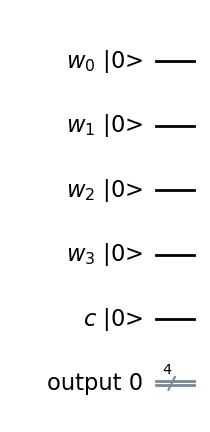

In [183]:
n_walker_qubits = 4  # The number of qubits used to represent the position of the walker


def coined_walk_circuit(
    n_walker_qubits: int,
) -> tuple[QuantumCircuit, QuantumRegister, QuantumRegister, ClassicalRegister]:
    """Create a quantum circuit for the quantum walk.

    Args:
        n_walker_qubits: number of qubits used to represent the position of the walker

    Returns:
        a tuple containing the circuit, the walker qubits, the coin qubits and the classical register to store the output
    """
    walker_r = QuantumRegister(n_walker_qubits, name="w")
    coin_r = QuantumRegister(1, name="c")  # The coin requires only one qubit
    classic_r = ClassicalRegister(n_walker_qubits, name="output")
    qc = QuantumCircuit(walker_r, coin_r, classic_r)
    return qc, walker_r, coin_r, classic_r


qc, _, _, _ = coined_walk_circuit(n_walker_qubits)
qc.draw(output="mpl", initial_state=True)


### Initial state of the circuit

The initial state of the circuit can be chosen arbitrarily.
The coin state can be either $\ket{0}$ or $\ket{1}$, and the walker position can be any number between $0$ and $2^n - 1$, although it convenient to choose the value closest to the middle: $2^{n-1}$.


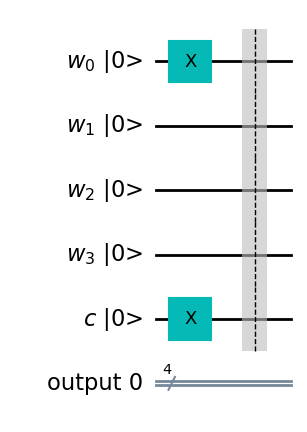

In [184]:
initial_position = 2 ** (
    n_walker_qubits - 1
)  # The initial position of the walker is the middle of all possible positions
initial_coin_value = 1  # The initial value of the coin is 0


def initialize_coined_walk_circuit(
    qc: QuantumCircuit,
    walker_r: QuantumRegister,
    coin_r: QuantumRegister,
    initial_position: int,
    initial_coin_value: int,
) -> QuantumCircuit:
    """Initialize the circuit with the initial position of the walker and the initial value of the coin.

    Args:
        qc: the quantum circuit
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit
        initial_position: the initial position of the walker
        initial_coin_value: the initial value of the coin

    Returns:
        the initialized quantum circuit
    """
    if initial_coin_value == 1:
        qc.x(coin_r)
    for i in range(n_walker_qubits):
        if initial_position & (1 << i):
            qc.x(walker_r[n_walker_qubits - i - 1])
    qc.barrier()
    return qc


qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = initialize_coined_walk_circuit(
    qc, walker_r, coin_r, initial_position, initial_coin_value
)
qc.draw(output="mpl", initial_state=True)


### Operators


#### Coin operator

For the coin operator, the simplest choice is to use the Hadamard gate.
When applied to the coin qubit, it will be put in a state of superposition.


#### Shift operator

The shift operator has to be able to either increment or decrement the walker position, depending on the state of the coin.
This can be achieved by using an addition operator, controlled by the coin state.  
Since all operators are unitary, once an addition operator $A$ is found, building a corresponding subtraction operator is trivial.

$$
A : \mathcal{H} \to \mathcal{H} : A\ket{j} = \ket{j + 1} \\
\exists A^\dagger \in \mathcal{H} : A^\dagger A = I \\
A^\dagger A \ket{j} = A^\dagger \ket{j + 1} \implies \ket{j} = A^\dagger \ket{j + 1} \implies A^\dagger \ket{k} = \ket{k - 1} \\
$$


#### Quantum walk operator

The quantum walk operator is the composition of the coin operator and the shift operator:

$$
U = S(C \otimes I)
$$


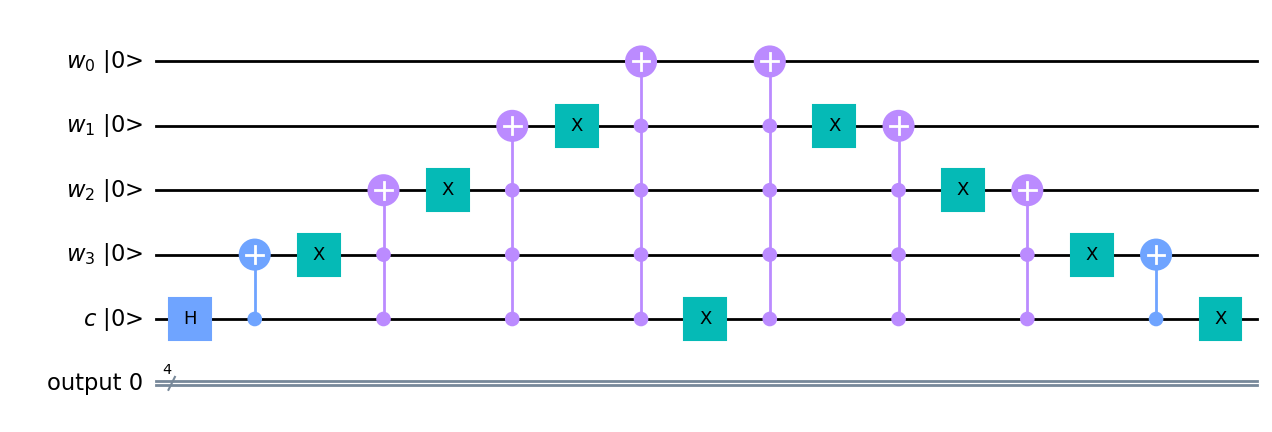

In [185]:
def coined_walk_step(
    qc: QuantumCircuit, walker_r: QuantumRegister, coin_r: QuantumRegister
) -> QuantumCircuit:
    """Single step of the quantum walk.

    Args:
        qc: quantum circuit
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit

    Returns:
        quantum circuit with an added walk step
    """

    # "Flip" the coin vector
    qc.h(coin_r)

    # Implement the Addition Operator
    for i in reversed(range(len(walker_r))):
        # Qubits with less significant bits than the current one
        controls = [walker_r[v] for v in range(len(walker_r) - 1, i, -1)]
        controls.append(coin_r)  # The coin qubit is also used as a control
        qc.mcx(controls, walker_r[i])  # Multi-controlled X gate
        if i != 0:
            qc.x(walker_r[i])  # Flip the qubit

    # Switch the coin vector
    qc.x(coin_r)

    # Implement the Subtraction Operator
    for i in range(len(walker_r)):
        if i != 0:
            qc.x(walker_r[i])  # Reverse the flip
        # Qubits with less significant bits than the current one
        controls = [walker_r[v] for v in range(len(walker_r) - 1, i, -1)]
        controls.append(coin_r)  # The coin qubit is also used as a control
        qc.mcx(controls, walker_r[i])  # Multi-controlled X gate

    # Revert the switch of the coin vector
    qc.x(coin_r)

    return qc


qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = coined_walk_step(qc, walker_r, coin_r)
qc.draw(output="mpl", initial_state=True)


### Circuit

With all the operators defined, the circuit can be built by iterating the single step operator as many times as needed.
Finally, the walker position is measured and the result is stored in the classical bits.


Mind that we could just take one step at a time and collapse the state of the circuit by measuring it.
This would be equivalent to a classical random walk, and would not take advantage of the quantum properties of the system.


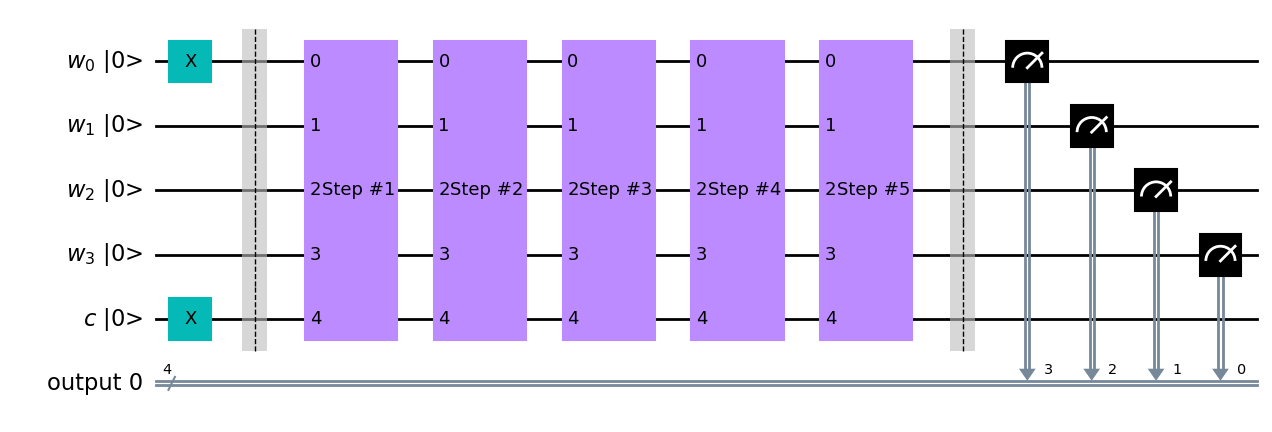

In [186]:
n_steps = 5  # The number of steps of the quantum walk


def coined_walk(
    n_walker_qubits: int,
    n_steps: int,
    initial_position: int,
    initial_coin_value: int,
    init_func: Callable,
) -> QuantumCircuit:
    """Create a quantum circuit for the quantum walk.

    Args:
        n_walker_qubits: number of qubits used to represent the position of the walker
        n_steps: number of steps of the quantum walk
        initial_position: initial position of the walker
        initial_coin_value: initial value of the coin
        init_func: function used to initialize the circuit

    Returns:
        quantum circuit for the quantum walk
    """
    qc, walker_r, coin_r, classic_r = coined_walk_circuit(n_walker_qubits)
    qc = init_func(qc, walker_r, coin_r, initial_position, initial_coin_value)
    for i in range(n_steps):
        step_gate = coined_walk_step(QuantumCircuit(walker_r, coin_r), walker_r, coin_r)
        qc.append(step_gate.to_gate(label=f"Step #{i + 1}"), walker_r[:] + coin_r[:])
    qc.barrier()
    qc.measure(walker_r, reversed(classic_r))
    return qc


qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_coined_walk_circuit,
)
qc.draw(output="mpl", initial_state=True)


## Results of the simulation

To get an idea of the behavior of the circuit, it is useful to plot multiple results obtained by running the Qiskit simulator.


### Skewed results

Contrary to the classical random walk, this circuit results are clearly skewed towards one side of the graph.
Inverting the initial coin state will result in a flipped graph.

The reason for this behavior originates from the repeated application of the Hadamard gate.
Depending on the starting state of the coin, $\ket{\downarrow}$ or $\ket{\uparrow}$, a bias will be introduced in the results.


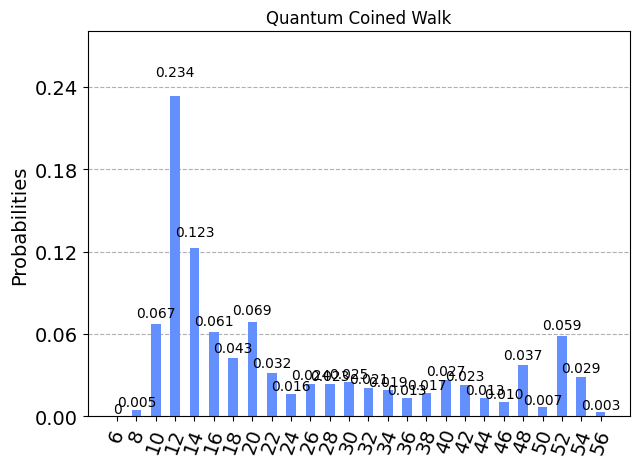

In [187]:
n_walker_qubits = 6  # The number of qubits used to represent the position of the walker
n_steps = 30  # The number of steps of the quantum walk
initial_position = 2 ** (
    n_walker_qubits - 1
)  # The initial position of the walker is the middle of all possible positions
initial_coin_value = 0  # The initial value of the coin is 0
n_runs = 5000  # The number of runs of the quantum circuit

qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_coined_walk_circuit,
)


def plot_results(qc: QuantumCircuit, n_runs: int, title: str):
    """Plot the results of the quantum walk.

    Args:
        qc: quantum circuit for the quantum walk
        n_runs: number of runs of the quantum circuit

    Returns:
        histogram of the results of the quantum walk
    """
    simulator: AerSimulator = Aer.get_backend("aer_simulator")
    transpiled_qc = transpile(qc, simulator)
    results = simulator.run(transpiled_qc, shots=n_runs).result()
    counts = results.get_counts(transpiled_qc)
    counts = {int(k, 2): v for k, v in counts.items()}
    return plot_histogram(counts, title=title)


plot_results(qc, n_runs, "Quantum Coined Walk")


### Math behind the skewed results

Starting from the initial state $\ket{\psi(0)} = \ket{\downarrow} \otimes \ket{0}$, the first iteration of the operator will result in the state $\ket{\psi(1)} = \frac{1}{\sqrt{2}}(\ket{\uparrow} \otimes \ket{1} + \ket{\downarrow} \otimes \ket{-1})$.
Going through the same process, the state after $t$ iterations will be:

$$
\begin{array}{ll}
\ket{\psi(0)} &= \ket{\downarrow} \otimes \ket{0} \\
\ket{\psi(1)} &= \frac{1}{\sqrt{2}}(\ket{\uparrow} \otimes \ket{1} + \ket{\downarrow} \otimes \ket{-1}) \\
\ket{\psi(2)} &= \frac{1}{2}(-\ket{\uparrow} \otimes \ket{-2} + (\ket{\downarrow} + \ket{\uparrow})\ket{0} + \ket{\downarrow} \otimes \ket{2}) \\
\ket{\psi(3)} &= \frac{1}{2\sqrt{2}}(\ket{\uparrow}\ket{-3} - \ket{\downarrow}\ket{-1} + (2\ket{\downarrow} + \ket{\uparrow})\ket{1} - \ket{\downarrow}\ket{3}) \\
\end{array}
$$

This few iterations are enough to see that the state is not balanced: the probability of finding the walker in the position $\ket{1}$ are $(\frac{2 + 1}{2\sqrt{2}})^2 = \frac{5}{8}$, as opposed to $\frac{1}{8}$ for all other positions.


### Balanced coin

To avoid this bias, why may use another coin, or ensure that the starting state of the coin is equal to $\frac{1}{\sqrt{2}}(\ket{\downarrow} + i \ket{\uparrow})$.
This can be achieved by applying a Hadamard gate followed by an $S$ gate to the coin qubit before starting the walk.


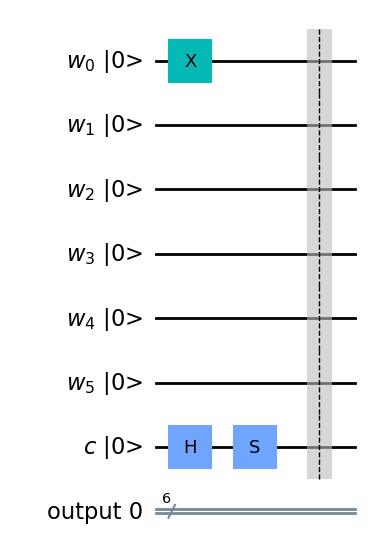

In [188]:
def initialize_balance_coined_walk_circuit(
    qc: QuantumCircuit,
    walker_r: QuantumRegister,
    coin_r: QuantumRegister,
    initial_position: int,
    initial_coin_value: int,
) -> QuantumCircuit:
    """Initialize the circuit with the initial position of the walker and the initial value of the coin.
    Set the coin qubit to |+> and apply the S gate to it to make sure that the coin operator keeps being balanced.

    Args:
        qc: the quantum circuit
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit
        initial_position: the initial position of the walker
        initial_coin_value: the initial value of the coin

    Returns:
        the initialized quantum circuit
    """
    if initial_coin_value == 1:
        qc.x(coin_r)
    qc.h(coin_r)
    qc.s(coin_r)
    for i in range(n_walker_qubits):
        if initial_position & (1 << i):
            qc.x(walker_r[n_walker_qubits - i - 1])
    qc.barrier()
    return qc


qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = initialize_balance_coined_walk_circuit(
    qc, walker_r, coin_r, initial_position, initial_coin_value
)
qc.draw(output="mpl", initial_state=True)


### Balanced coin results

Having the coin in this starting state produces results that are more evenly distributed across the graph.


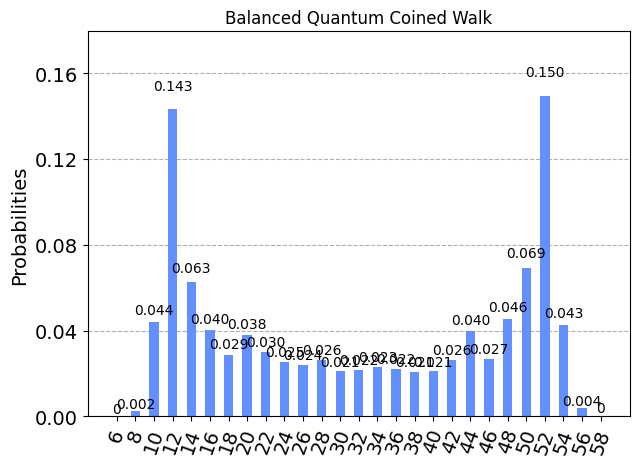

In [189]:
n_walker_qubits = 6  # The number of qubits used to represent the position of the walker
n_steps = 30  # The number of steps of the quantum walk
initial_position = 2 ** (
    n_walker_qubits - 1
)  # The initial position of the walker is the middle of all possible positions
initial_coin_value = 0  # The initial value of the coin is 0
n_runs = 5000  # The number of runs of the quantum circuit

qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_balance_coined_walk_circuit,
)

plot_results(qc, n_runs, "Balanced Quantum Coined Walk")


## Conclusion

When compared to the classical random walk, it becomes clear that the quantum coined walk results lack the Gaussian properties of the classical random walk.
The statistical analysis of its behavior becomes more difficult.

On the other hand, in can be proven that the standard deviation of the distribution, its width, is $t$, when the classical counterpart has a standard deviation of $\sqrt{t}$.
The quantum walk travel much further than a classical walk with the same number of steps.  
This allows certain problems to be solved more efficiently with a quantum approach, such as Grover's search algorithm.


## Quantum walk on a hypercube

The quantum random walk can be used to walk on the vertices of a hypercube.


### Hypercube

A hypercube with degree $n$ is a graph with $2^n$ vertices, where each vertex is connected to all the other vertices that differ by a single bit.


> _Example_
>
> A 4-dimesional hypercube has $2^4 = 16$ nodes.  
> The neighbors of the node $\ket{0101}$ are $\ket{1101}$, $\ket{0001}$, $\ket{0111}$ and $\ket{0110}$.


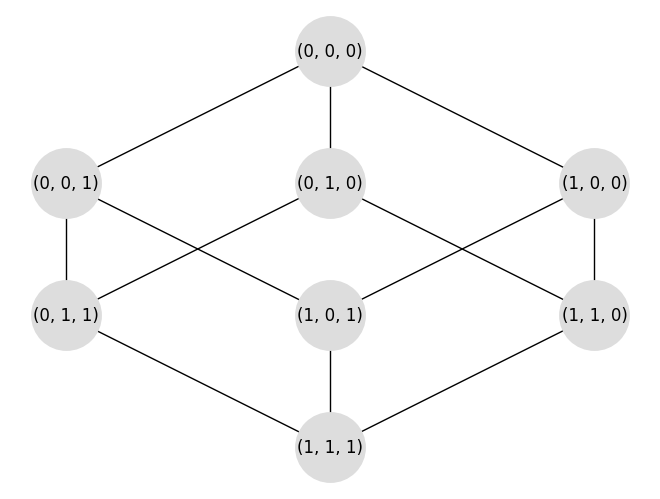

In [190]:
n = 3  # Number of qubits

G = hypercube_graph(n)  # Create hypercube graph
# Draw graph
nx.draw(
    G,
    with_labels=True,
    pos=graphviz_layout(G, prog="dot"),
    node_color="#dddddd",
    node_size=2500,
)
plt.show()


### State of the quantum walk circuit

The state of the system needs to account for coin space, $\mathcal{H}_c = \mathcal{H}^n$, and walker space, $\mathcal{H}_p = \mathcal{H}^{2^n}$.
The two spaces are then combined to form the state of the system, $\mathcal{H} = \mathcal{H}_c \otimes \mathcal{H}_p$.


It is possible to define $\mathcal{H}$ as $\{\ket{a} \otimes \ket{v}: 0 \le a \lt n, v \in \{(00 \dots 00)_2, (00\dots 01)_2, \dots, (11 \dots 11)\}\}$.


The value of $a$ decides where the walker should move next, inverting the value of the bit at position $a$ of $v$.


> _Example_
>
> The state $\ket{a} \otimes \ket{v} = \ket{2} \otimes \ket{0101}$.
> The walker will move to the node $\ket{0001}$, since the bit at position 2 is inverted.


### Quantum registers

A circuit implementing a quantum coined needs:

- $n$ qubits to represent the coin
- $2^n$ qubits to represent the walker position
  - the numbers are represented in binary form, with the most significant bit at the top
- $2^n$ classical bits to store the measurement of the walker position


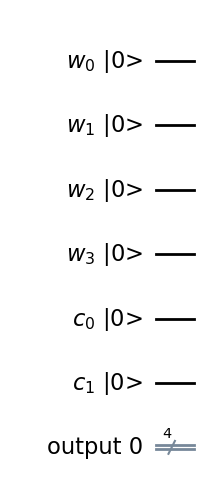

In [191]:
n = 2  # Dimension of the hypercube


def graph_walk_circuit(
    n: int,
) -> tuple[QuantumCircuit, QuantumRegister, QuantumRegister, ClassicalRegister]:
    """Create a quantum circuit for the graph walk.

    Args:
        n: number of qubits used to represent the position of the walker

    Returns:
        quantum circuit for the graph walk, walker register, coin register, and output register
    """
    walker_r = QuantumRegister(2**n, name="w")
    coin_r = QuantumRegister(n, name="c")
    classic_r = ClassicalRegister(2**n, name="output")
    qc = QuantumCircuit(walker_r, coin_r, classic_r)
    return qc, walker_r, coin_r, classic_r


qc, _, _, _ = graph_walk_circuit(n)
qc.draw(output="mpl", initial_state=True)


### Operators


#### Coin operator

In this case, the coin operator is the Grover coin, $C$.
It is defined as:

$$
C = \begin{bmatrix}
\frac{2}{n} - 1& \frac{2}{n} & \dots & \frac{2}{n} \\
\frac{2}{n} & \frac{2}{n} - 1& \dots &  \frac{2}{n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{2}{n} & \frac{2}{n} & \dots & \frac{2}{n} - 1
\end{bmatrix}
$$


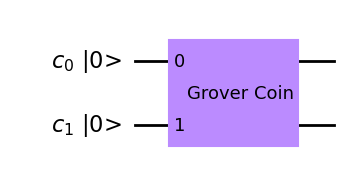

In [192]:
n = 2  # Dimension of the hypercube

def grover_coin(coin_r: QuantumRegister) -> Operator:
    matrix_size = 2 ** len(coin_r)
    grover_matrix = np.full((matrix_size, matrix_size), 2 / matrix_size) - np.eye(
        matrix_size
    )
    return Operator(grover_matrix)


coin_r = QuantumRegister(n, name="c")
qc = QuantumCircuit(coin_r)
gc = grover_coin(coin_r)
qc.unitary(gc, coin_r[:], label="Grover Coin")
qc.draw(output="mpl", initial_state=True)


#### Shift operator

Let $e_a$ be the vector with a single 1 at position $a$ and 0s everywhere else.
The shift operator $S$ is defined as:

$$
S(\ket{a} \otimes \ket{v}) = \ket{a} \otimes \ket{v \oplus e_a}
$$


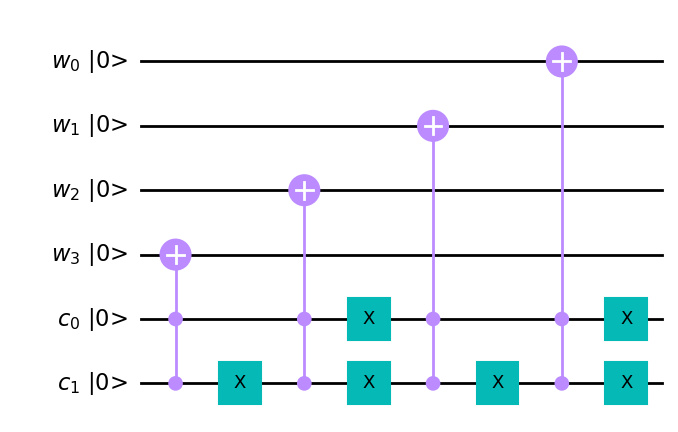

In [193]:
n = 2  # Dimension of the hypercube


def shift_operator(
    walker_r: QuantumRegister, coin_r: QuantumRegister
) -> QuantumCircuit:
    """Create a quantum circuit for the shift operator.

    Args:
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit

    Returns:
        quantum circuit for the shift operator
    """
    qc = QuantumCircuit(walker_r, coin_r)
    for i in reversed(range(len(walker_r))):
        qc.mcx(coin_r, walker_r[i])
        qc.x(coin_r[-1])
        for j in range(1, len(coin_r)):
            if i & ((1 << j) - 1) == 0:
                qc.x(coin_r[-(j + 1)])
    return qc


qc, walker_r, coin_r, _ = graph_walk_circuit(n)
qc = shift_operator(walker_r, coin_r)
qc.draw(output="mpl", initial_state=True)


#### Quantum walk operator

The quantum walk operator is the composition of the coin operator and the shift operator:

$$
U = S(C \otimes I)
$$


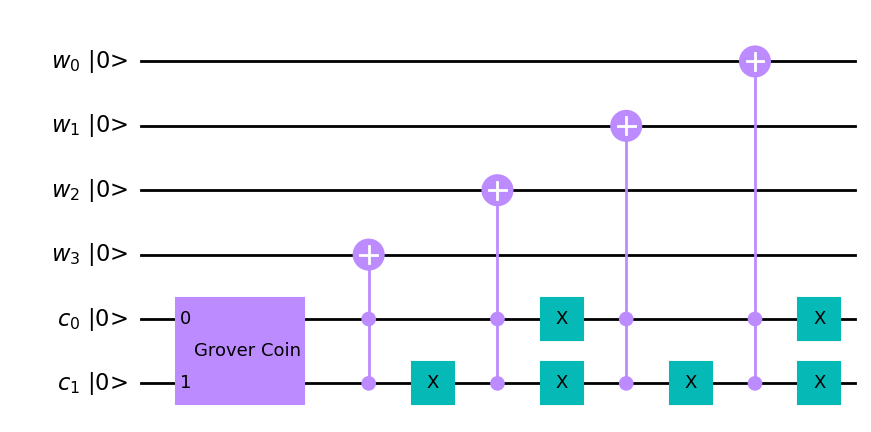

In [194]:
n = 2  # Dimension of the hypercube


def graph_walk_step(
    walker_r: QuantumRegister, coin_r: QuantumRegister
) -> QuantumCircuit:
    """Create a quantum circuit for one step of the graph walk.

    Args:
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit

    Returns:
        quantum circuit for one step of the graph walk
    """
    shift = shift_operator(walker_r, coin_r)
    gc = grover_coin(coin_r)
    walk_step = QuantumCircuit(walker_r, coin_r)
    walk_step.unitary(gc, coin_r, label="Grover Coin")
    walk_step.compose(shift, inplace=True)
    return walk_step


walk_step = graph_walk_step(walker_r, coin_r)
walk_step.draw(output="mpl", initial_state=True)


### Circuit

With all the operators defined, the circuit can be built by iterating the single step operator as many times as needed.
Finally, the walker position is measured and the result is stored in the classical bits.


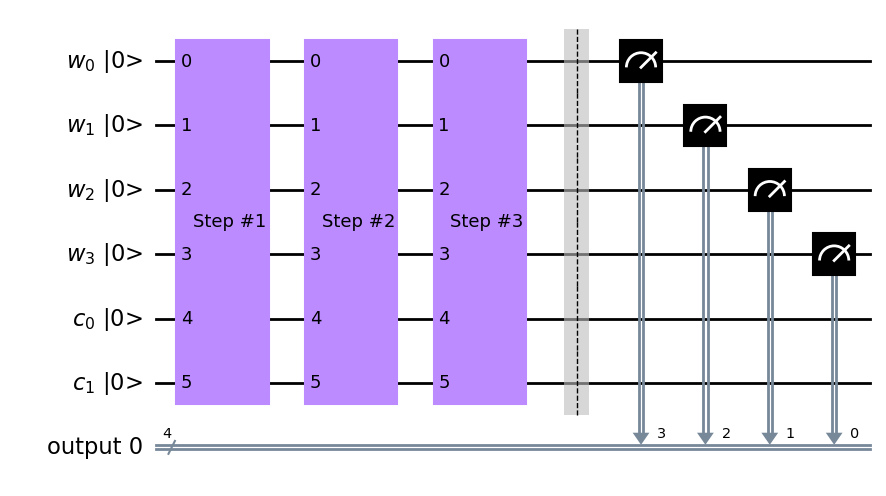

In [195]:
n = 2  # Dimension of the hypercube
n_steps = 3  # Number of steps of the quantum walk


def graph_walk(
    n: int,
    n_steps: int,
) -> QuantumCircuit:
    """Create a quantum circuit for the quantum walk over a graph.

    Args:
        n: dimension of the hypercube
        n_steps: number of steps of the quantum walk
        initial_position: initial position of the walker
        initial_coin_value: initial value of the coin

    Returns:
        quantum circuit for the quantum walk over a graph
    """
    qc, walker_r, coin_r, classic_r = graph_walk_circuit(n)
    for i in range(n_steps):
        step_gate = graph_walk_step(walker_r, coin_r).to_gate(label=f"Step #{i + 1}")
        qc.append(step_gate, walker_r[:] + coin_r[:])
    qc.barrier()
    qc.measure(walker_r, reversed(classic_r))
    return qc


qc = graph_walk(n, n_steps)
qc.draw(output="mpl", initial_state=True)


## Results of the simulation

The selection of the coin operator determines the behavior of the quantum walk.
The Grover coin is used to produce a biased walk.

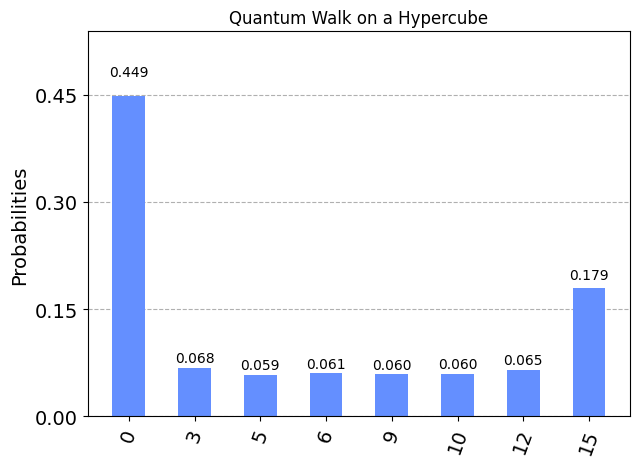

In [196]:
n = 2  # Dimension of the hypercube
n_steps = 30  # Number of steps of the quantum walk
n_runs = 5000  # Number of runs of the quantum circuit

qc = graph_walk(n, n_steps)
plot_results(qc, n_runs, "Quantum Walk on a Hypercube")


### Conclusion

A radom walk on a hypercube could be used to simulate efficiently network routing.
A hypercube structure is particularly suited for this task in a distributed environment, since deleting an edge will have a minimal impact on the network.

## References

- [Quantum Walk Search Algorithm](https://qiskit.org/textbook/ch-algorithms/quantum-walk-search-algorithm.html)
- [An Insight Into: Quantum Random Walks](https://bayesianbrad.github.io/assets/publications/2014_thesis/paper.pdf)
- [Quantum Walks and Search Algorithms](http://ndl.ethernet.edu.et/bitstream/123456789/73178/1/277.pdf)
- [Quantum Walk](https://quantumai.google/cirq/experiments/quantum_walks)
